# Training a deep Boltzmann machine (DBM)
### Application to the MNIST dataset

YJ Choe (yojoongc@andrew.cmu.edu)

#### Setup

In [1]:
%cd ../code/NN/

/Users/YJ/Dropbox/Code/deep_learning/hw3/code/NN


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dbm import DBM
from nn.nn import NN
from nn.utils import load_data, binarize_data
from nn.visualization import print_image

#### Load and binarize data

In [3]:
X_train, X_valid, X_test, y_train, y_valid, y_test = \
    load_data('../../data/digitstrain.txt',
              '../../data/digitsvalid.txt',
              '../../data/digitstest.txt')

In [4]:
X_train.shape, y_train.shape

((3000, 784), (3000, 10))

In [5]:
X_train = binarize_data(X_train)
X_valid = binarize_data(X_valid)
X_test  = binarize_data(X_test)

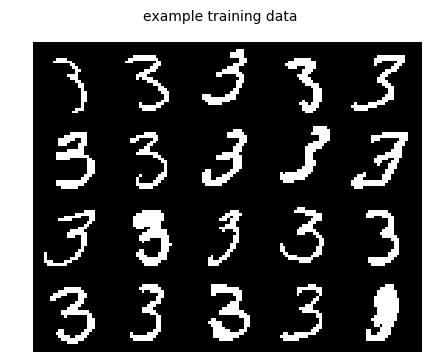

In [6]:
print_image(X_train[1160:1180, :], output_shape=(4, 5), 
            title='example training data')
None # should be binarized

## (a) Basic generalization

### Model initialization

Weights $W \in \mathbb{R}^{n \times m}$ are initialized from a $\mathrm{Unif}(-u, u)$ where $u = \frac{\sqrt{6}}{\sqrt{n+m}}$, as described in the lecture. Bias terms are initialized to zero.

Learning rate is halved after every 100 epochs.

In [11]:
dbm = DBM(n_visible=784, n_hidden1=100, n_hidden2=100,
          n_chains=100, n_vi_steps=10, n_gibbs_steps=1,
          learning_rate=0.01, early_stopping=True,
          seed=21)

In [12]:
dbm.W1.shape, dbm.W2.shape, dbm.b1.shape, dbm.b2.shape, dbm.c.shape

((100, 784), (100, 100), (100, 1), (100, 1), (784, 1))

### Training

Cross-entropy error is computed as the average over all training (or validation) dataset and summed over all dimensions. 

_Note that we use a very small batch size, which (as a side effect) leads to a longer CD Gibbs chain._

In [ ]:
n_epoch = 30
dbm.train(X_train, X_valid,
          batch_size=1, n_epoch=n_epoch, batch_seed=24, 
          verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         153.58135         |         155.33991         |
|    2  |         140.55544         |         143.77202         |
|    3  |         123.59659         |         128.00627         |
|    4  |         125.13723         |         129.50107         |
|    5  |         120.63575         |         125.89254         |
|    6  |         116.82465         |         122.42899         |
|    7  |         117.31813         |         122.79714         |
|    8  |         105.77470         |         112.05917         |
|    9  |         109.74944         |         116.15070         |
|   10  |         109.40315         |         116.95063         |
|   11  | 

In [10]:
dbm.save('../../models/dbm-{}-{}-{}-{}-{}-{}-{}-{}.pkl'.format(
         dbm.n_hidden1, dbm.n_hidden2, dbm.n_chains, 
         dbm.n_vi_steps, dbm.n_gibbs_steps, 
         dbm.learning_rate.const, dbm.early_stopping,
         dbm.epoch))
None

Next, we show the plots of training and validation errors. The validation error starts to go up at around 130 epochs.

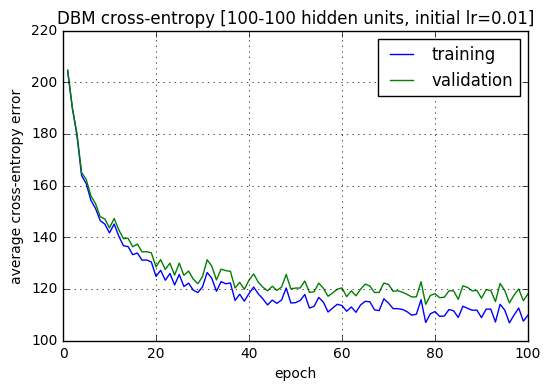

In [12]:
plt.grid()
plt.plot(*zip(*dbm.training_error), label='training')
plt.plot(*zip(*dbm.validation_error), label='validation')
plt.title('DBM cross-entropy [100-100 hidden units, initial lr={:.2f}]'.format(dbm.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

As requested in the homework, we now train 5 more neural networks with different initializations.

In [11]:
dbms = [dbm]
n_epoch = 30
for i in range(1, 6):
    dbm0 = DBM(n_visible=784, n_hidden1=100, n_hidden2=100,
               n_chains=100, n_vi_steps=10, n_gibbs_steps=1,
               learning_rate=0.01, early_stopping=True,
               seed=44*i)
    dbm0.train(X_train, X_valid,
               batch_size=2, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    dbms.append(dbm0)
    print('DBM #{:d} training complete ({:d} epochs)'.format(i, n_epoch))
    print('Final training error: {:.5f}'.format(dbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(dbm0.validation_error[-1][1]))

RBM #1 training complete (500 epochs)
Final training error: 62.90945
Final validation error: 77.32885
RBM #2 training complete (500 epochs)
Final training error: 62.77037
Final validation error: 77.72959
RBM #3 training complete (500 epochs)
Final training error: 63.06907
Final validation error: 77.36504
RBM #4 training complete (500 epochs)
Final training error: 62.97604
Final validation error: 77.16100
RBM #5 training complete (500 epochs)
Final training error: 63.57336
Final validation error: 77.23927


It appears that the validation cross-entropy errors are roughly the same across different initializations. We proceed with the first model.

### Visualizing parameters

First, we take the first hidden layer units and plot them as images. As shown below, the filters seem to capture digit-like shapes, as we saw with 2-layer feedforward neural networks. 

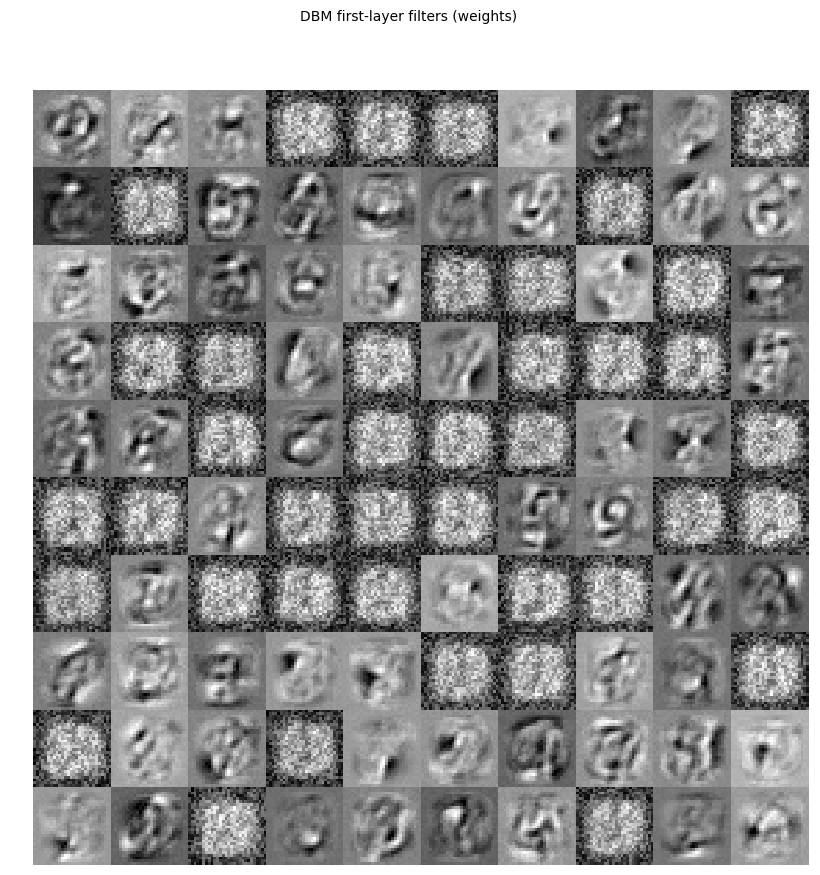

In [13]:
assert dbm.W1.shape[0] >= 100
print_image(dbm.W1[:100,:], output_shape=(10, 10),
            title='DBM first-layer filters (weights)')
None

Next, we generate 25 hidden states from a random sample of the training data of size 25. The hidden units don't appear to capture any particular structure, but overall they tend to be sparser than that of RBMs.

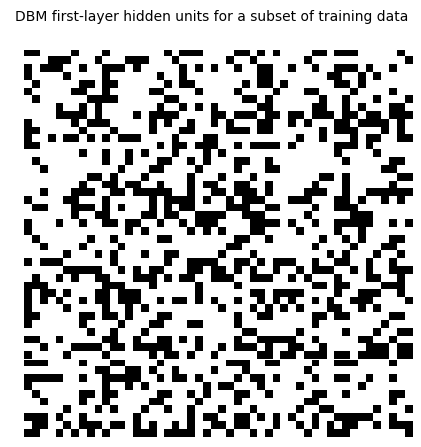

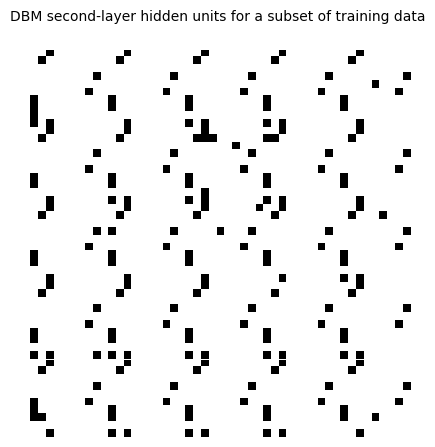

In [16]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 25, replace=False)

_, h1, h2 = dbm.run_gibbs(X_train[subset, :])
print_image(h1, output_shape=(5, 5),
            title='DBM first-layer hidden units for a subset of training data')
print_image(h2, output_shape=(5, 5),
            title='DBM second-layer hidden units for a subset of training data')
None

Finally, we generate 25 new negative samples randomly generated from the trained RBM. These actually look pretty similar to real digits but with some noise.

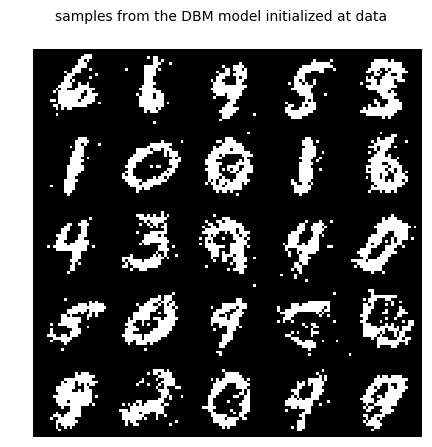

In [15]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 25, replace=False)

X_neg = dbm.generate_negative_sample(X_train[subset, :])
print_image(X_neg, output_shape=(5, 5),
            title='samples from the DBM model initialized at data')
None

## (b) Samples from the DBM model

Here we take 100 samples of new images from the trained model by starting from 100 random visible units and running 1000 steps of Gibbs sampling for each of the 100 random inputs. 

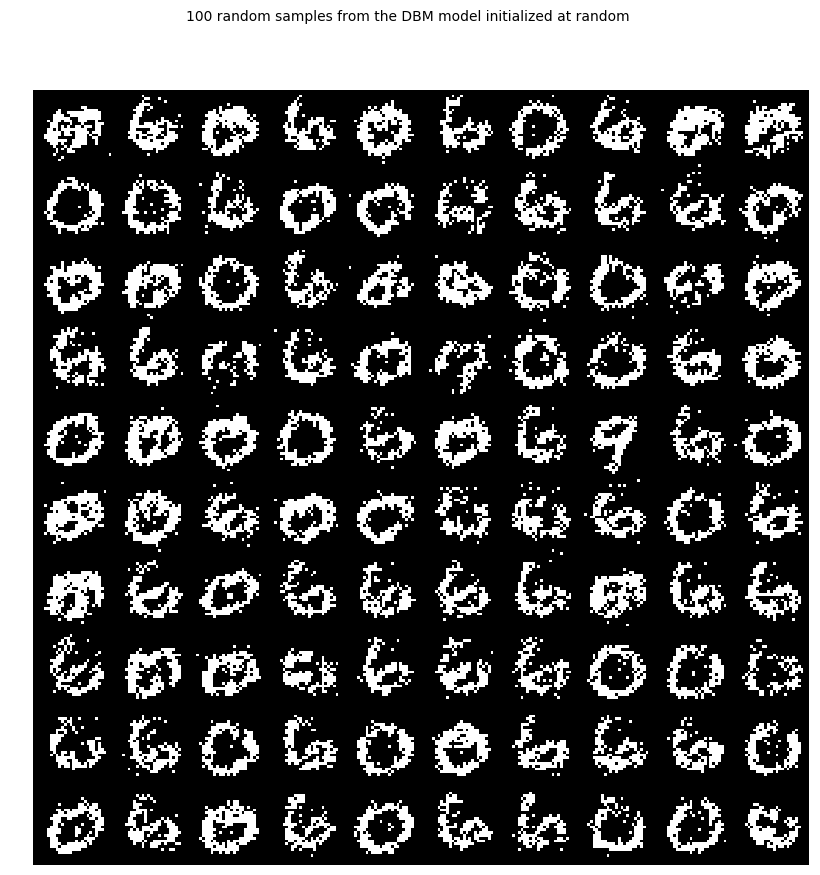

In [18]:
# Set the number of Gibbs steps to 1000
dbm.n_gibbs_steps = 1000
# Generate 100 random initial samples
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
# Run Gibbs steps
X_new    = dbm.generate_negative_sample(X_random)
# Reset to default
dbm.n_gibbs_steps = 1
# Print digits
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the DBM model initialized at random')
None

While they don't look like perfect digits, they definitely resemble some of the digits. We can perhaps fine-tune this model and run more extensively to obtain perfect digits.

## (c) Comparisons to a single-layer RBM model

We now train a single-layer RBM using persistent contrastive divergence and compare the samples.

In [ ]:
rbm = RBM(n_visible=784, n_hidden=100, k=1, persistent=True,
          learning_rate=0.01, early_stopping=True,
          seed=21)
rbm.train(X_train, X_valid,
          batch_size=1, n_epoch=n_epoch, batch_seed=24, 
          verbose=True)
None

In [ ]:
plt.grid()
plt.plot(*zip(*rbm.training_error), label='training')
plt.plot(*zip(*rbm.validation_error), label='validation')
plt.title('RBM cross-entropy [100 hidden units, initial lr={:.2f}]'.format(rbm.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

We analogously generate 100 samples from random initialization, using 1000 Gibbs steps:

In [ ]:
rbm.k = 1000
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))
X_new    = rbm.generate_negative_sample(X_random)
rbm.k = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the RBM model initialized at random')
None

## (d) Number of hidden units

We now validate over the number of hidden units. 

In [20]:
dbms = []
n_hidden_units = [200, 400]
for i, n_hidden in enumerate(n_hidden_units):
    dbm0 = DBM(n_visible=784, n_hidden1=n_hidden, n_hidden2=n_hidden,
               n_chains=100, n_vi_steps=10, n_gibbs_steps=1,
               learning_rate=0.01, early_stopping=True,
               seed=7)
    dbm0.train(X_train, X_valid,
               batch_size=1, n_epoch=n_epoch, batch_seed=25, 
               verbose=False)  # silent run
    dbms.append(dbm0)
    print('DBM #{:d} with {:d} hidden units training complete ({:d} epochs)'.format(i, n_hidden, n_epoch))
    print('Final training error: {:.5f}'.format(dbm0.training_error[-1][1]))
    print('Final validation error: {:.5f}'.format(dbm0.validation_error[-1][1]))

RBM #0 with 50 hidden units training complete (400 epochs)
Final training error: 91.73496
Final validation error: 100.66532
RBM #1 with 100 hidden units training complete (400 epochs)
Final training error: 63.94774
Final validation error: 77.90195
RBM #2 with 200 hidden units training complete (400 epochs)
Final training error: 40.51797
Final validation error: 59.44309
RBM #3 with 500 hidden units training complete (400 epochs)
Final training error: 20.89034
Final validation error: 43.58663


It appears that using more units directly lead to smaller cross-entropy error, at least within 40 epochs. One may want to worry about overfitting here. We generate 1000-step Gibbs samples from the 200-unit and 400-unit DBMs below (respectively):

In [ ]:
X_random = rng.binomial(1, 0.5*np.ones((100, 784)))

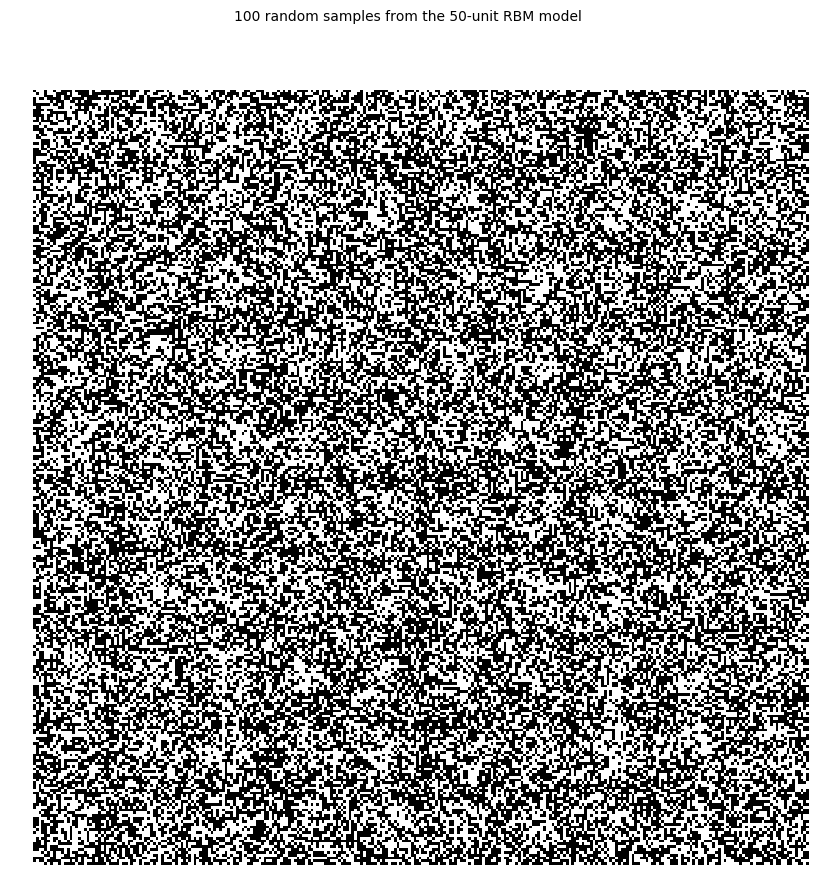

In [26]:
dbm200 = rbms[0]
dbm200.n_gibbs_steps = 1000
X_new = dbm200.generate_negative_sample(X_random)
dbm200.n_gibbs_steps = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the 200-hidden-unit DBM model')
None

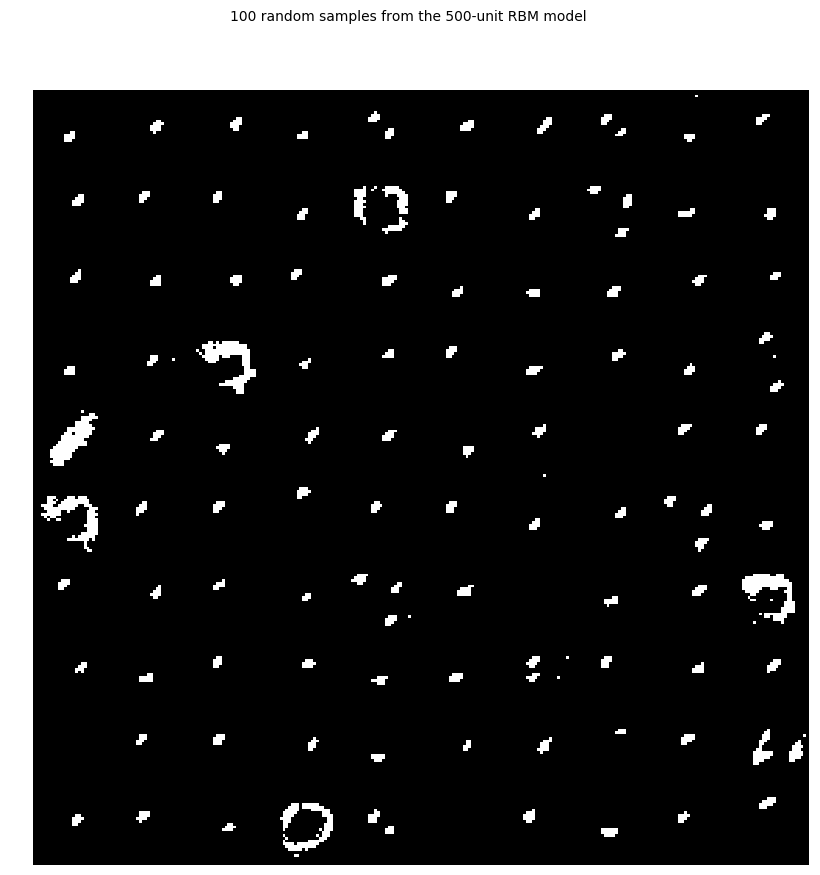

In [27]:
dbm400 = rbms[0]
dbm400.n_gibbs_steps = 1000
X_new = dbm400.generate_negative_sample(X_random)
dbm400.n_gibbs_steps = 1
print_image(X_new, output_shape=(10, 10),
            title='100 random samples from the 200-hidden-unit DBM model')
None